# WorkFlow

## Classes

## Load the data

## Test Modelling

## Modelling

**<hr>**

## Classes

In [1]:
NAME = "change the conv2d"

In [2]:
BATCH_SIZE = 32

In [3]:
import os
import cv2
import torch
import numpy as np

In [4]:
def load_data(img_size=112):
    data = []
    index = -1
    labels = {}
    for directory in os.listdir('./data/'):
        index += 1
        labels[f'./data/{directory}/'] = [index,-1]
    print(len(labels))
    for label in labels:
        for file in os.listdir(label):
            filepath = label + file
            img = cv2.imread(filepath,cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img,(img_size,img_size))
            img = img / 255.0
            data.append([
                np.array(img),
                labels[label][0]
            ])
            labels[label][1] += 1
    for _ in range(12):
        np.random.shuffle(data)
    print(len(data))
    np.save('./data.npy',data)
    return data

In [5]:
import torch

In [6]:
def other_loading_data_proccess(data):
    X = []
    y = []
    print('going through the data..')
    for d in data:
        X.append(d[0])
        y.append(d[1])
    print('splitting the data')
    VAL_SPLIT = 0.25
    VAL_SPLIT = len(X)*VAL_SPLIT
    VAL_SPLIT = int(VAL_SPLIT)
    X_train = X[:-VAL_SPLIT]
    y_train = y[:-VAL_SPLIT]
    X_test = X[-VAL_SPLIT:]
    y_test = y[-VAL_SPLIT:]
    print('turning data to tensors')
    X_train = torch.from_numpy(np.array(X_train))
    y_train = torch.from_numpy(np.array(y_train))
    X_test = torch.from_numpy(np.array(X_test))
    y_test = torch.from_numpy(np.array(y_test))
    return [X_train,X_test,y_train,y_test]

**<hr>**

## Load the data

In [7]:
REBUILD_DATA = True
if REBUILD_DATA:
    data = load_data()
    np.random.shuffle(data)
    X_train,X_test,y_train,y_test = other_loading_data_proccess(data)

36
2515


/home/indika/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


going through the data..
splitting the data
turning data to tensors


## Test Modelling

In [8]:
import torch
import torch.nn as nn

In [9]:
import torch.nn.functional as F

In [10]:
# class Test_Model(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(1, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 25 * 25, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 36)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 25 * 25)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

In [11]:
class Test_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv3 = nn.Conv2d(32,64,5)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.fc1 = nn.Linear(128 * 10 * 10, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128, 36)

    def forward(self, x,shape=False):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if shape:
            print(x.shape)
        x = x.view(-1, 128 * 10 * 10)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc4(x))
        x = self.fc3(x)
        return x

In [12]:
device = torch.device('cuda')

In [13]:
model = Test_Model().to(device)

In [14]:
preds = model(X_test.reshape(-1,1,112,112).float().to(device),True)

torch.Size([628, 128, 10, 10])


In [15]:
preds[0]

tensor([ 0.0161,  0.0392,  0.0411, -0.0791,  0.0841,  0.0548,  0.0321, -0.0602,
        -0.0350,  0.0558,  0.0640,  0.0343, -0.0552, -0.0280,  0.0746, -0.0870,
         0.0193,  0.0623, -0.0182, -0.0519,  0.0717,  0.0546,  0.0588,  0.0184,
         0.0486,  0.0082,  0.0209,  0.0874, -0.0962,  0.0111,  0.0871, -0.0208,
        -0.0837, -0.0401,  0.0731,  0.0743], device='cuda:0',
       grad_fn=<SelectBackward>)

In [16]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
criterion = nn.CrossEntropyLoss()

In [17]:
EPOCHS = 5

In [18]:
loss_logs = []

In [19]:
from tqdm import tqdm

In [20]:
PROJECT_NAME = "Sign-Language-Recognition"

In [21]:
def test(net,X,y):
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for i in range(len(X)):
            real_class = torch.argmax(y[i]).to(device)
            net_out = net(X[i].view(-1,1,112,112).to(device).float())
            net_out = net_out[0]
            predictied_class = torch.argmax(net_out)
            if predictied_class == real_class:
                correct += 1
            total += 1
    return round(correct/total,3)

In [22]:
import wandb

In [23]:
len(os.listdir('./data/'))

36

In [24]:
import random

In [25]:
# index = random.randint(0,29)
# print(index)
# wandb.init(project=PROJECT_NAME,name=NAME)
# for _ in tqdm(range(EPOCHS)):
#     for i in range(0,len(X_train),BATCH_SIZE):
#         X_batch = X_train[i:i+BATCH_SIZE].view(-1,1,112,112).to(device)
#         y_batch = y_train[i:i+BATCH_SIZE].to(device)
#         model.to(device)
#         preds = model(X_batch.float())
#         loss = criterion(preds,torch.tensor(y_batch,dtype=torch.long))
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         wandb.log({'loss':loss.item(),'accuracy':test(model,X_train,y_train)*100,'val_accuracy':test(model,X_test,y_test)*100,'pred':torch.argmax(preds[index]),'real':torch.argmax(y_batch[index])})
# wandb.finish()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd

In [ ]:
df = pd.Series(loss_logs)

/home/indika/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

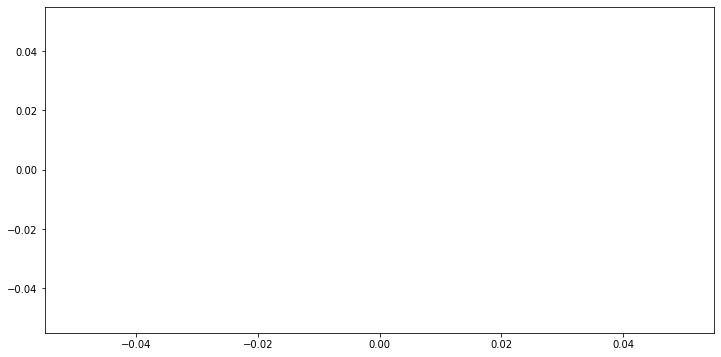

In [ ]:
df.plot.line(figsize=(12,6))

In [ ]:
test(model,X_test,y_test)

0.0

In [ ]:
test(model,X_train,y_train)

0.0

In [ ]:
preds

tensor([[ 0.0161,  0.0392,  0.0411,  ..., -0.0401,  0.0731,  0.0743],
        [ 0.0171,  0.0397,  0.0411,  ..., -0.0407,  0.0736,  0.0751],
        [ 0.0151,  0.0394,  0.0404,  ..., -0.0403,  0.0726,  0.0738],
        ...,
        [ 0.0168,  0.0402,  0.0409,  ..., -0.0400,  0.0744,  0.0741],
        [ 0.0157,  0.0400,  0.0408,  ..., -0.0407,  0.0734,  0.0744],
        [ 0.0167,  0.0390,  0.0415,  ..., -0.0400,  0.0733,  0.0746]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
X_testing = X_train
y_testing = y_train
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for i in range(len(X_testing)):
        real_class = torch.argmax(y_testing[i]).to(device)
        net_out = model(X_testing[i].view(-1,1,112,112).to(device).float())
        net_out = net_out[0]
        predictied_class = torch.argmax(net_out)
#         print(predictied_class)
        if str(predictied_class) == str(real_class):
            correct += 1
        total += 1
print(round(correct/total,3))

0.0


In [ ]:
# for real,pred in zip(y_batch,preds):
#     print(real)
#     print(torch.argmax(pred))
#     print('\n')

## Modelling

In [ ]:
# conv2d_output
# conv2d_1_ouput
# conv2d_2_ouput
# output_fc1
# output_fc2
# output_fc4
# max_pool2d_keranl
# max_pool2d
# num_of_linear

# activation
# best num of epochs
# best optimizer
# best loss
## best lr

In [ ]:
class Test_Model(nn.Module):
    def __init__(self,conv2d_output=128,conv2d_1_ouput=32,conv2d_2_ouput=64,output_fc1=512,output_fc2=256,output_fc4=128,output=36,activation=F.relu,max_pool2d_keranl=2):
        super().__init__()
        print(conv2d_output)
        print(conv2d_1_ouput)
        print(conv2d_2_ouput)
        print(output_fc1)
        print(output_fc2)
        print(output_fc4)
        print(activation)
        self.conv2d_output = conv2d_output
        self.pool = nn.MaxPool2d(max_pool2d_keranl)
        self.conv1 = nn.Conv2d(1, conv2d_1_ouput, 5)
        self.conv3 = nn.Conv2d(conv2d_1_ouput,conv2d_2_ouput,5)
        self.conv2 = nn.Conv2d(conv2d_2_ouput, conv2d_output, 5)
        self.fc1 = nn.Linear(conv2d_output * 10 * 10, output_fc1)
        self.fc2 = nn.Linear(output_fc1, output_fc2)
        self.fc4 = nn.Linear(output_fc2,output_fc4)
        self.fc3 = nn.Linear(output_fc4, output)
        self.activation = activation

    def forward(self, x,shape=False):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv3(x)))
        x = self.pool(self.activation(self.conv2(x)))
        if shape:
            print(x.shape)
        x = x.view(-1, self.conv2d_output * 10 * 10)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc4(x))
        x = self.fc3(x)
        return x

In [ ]:
# conv2d_output
# conv2d_1_ouput
# conv2d_2_ouput
# output_fc1
# output_fc2
# output_fc4
# max_pool2d_keranl
# max_pool2d
# num_of_linear
# best num of epochs
# best loss
## best lr
# batch size

In [ ]:
EPOCHS = 3
BATCH_SIZE = 32

In [ ]:
# conv2d_output
# conv2d_1_ouput
# conv2d_2_ouput
# output_fc1
# output_fc2
# output_fc4
# max_pool2d_keranl
# max_pool2d
# num_of_linear

# activation = 
# best num of epochs
# best optimizer = 
## best lr

In [ ]:
def get_loss(criterion,y,model,X):
    preds = model(X.view(-1,1,112,112).to(device).float())
    preds.to(device)
    loss = criterion(preds,torch.tensor(y,dtype=torch.long).to(device))
    loss.backward()
    return loss.item()

In [ ]:
lrs = [1.0,0.25,0.50,0.75,0.1,0.01,0.001]
for lr in lrs:
    model = Test_Model(activation=nn.SELU())
    optimizer = torch.optim.Adadelta(model.parameters(),lr=lr)
    criterion = nn.CrossEntropyLoss()
    wandb.init(project=PROJECT_NAME,name=f'lr-{lr}')
    for _ in tqdm(range(EPOCHS)):
        for i in range(0,len(X_train),BATCH_SIZE):
            X_batch = X_train[i:i+BATCH_SIZE].view(-1,1,112,112).to(device)
            y_batch = y_train[i:i+BATCH_SIZE].to(device)
            model.to(device)
            preds = model(X_batch.float())
            loss = criterion(preds,torch.tensor(y_batch,dtype=torch.long))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            wandb.log({'loss':loss.item(),'accuracy':test(model,X_train,y_train)*100,'val_accuracy':test(model,X_test,y_test)*100,'val_loss':get_loss(criterion,y_test,model,X_test)})
        print(f'{torch.argmax(preds[1])} \n {y_batch[1]}')
        print(f'{torch.argmax(preds[2])} \n {y_batch[2]}')
        print(f'{torch.argmax(preds[3])} \n {y_batch[3]}')
        print(f'{torch.argmax(preds[4])} \n {y_batch[4]}')
    wandb.finish()

128
32
64
512
256
128
SELU()


wandb: Currently logged in as: ranuga-d (use `wandb login --relogin` to force relogin)


  0%|          | 0/3 [00:00<?, ?it/s]/home/indika/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/home/indika/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
 33%|███▎      | 1/3 [01:46<03:32, 106.01s/it]

5 
 5
29 
 29
25 
 21
12 
 12


 67%|██████▋   | 2/3 [03:27<01:43, 103.54s/it]

5 
 5
15 
 29
25 
 21
12 
 12


100%|██████████| 3/3 [05:09<00:00, 103.27s/it]

5 
 5
29 
 29
21 
 21
12 
 12


loss,0.15912
accuracy,3.3
val_accuracy,4.9
val_loss,0.37182
_runtime,316
_timestamp,1621321234
_step,176


loss,▂█▄▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▁▁▁▁▃▁▁▇▁▁█▂▂▄▃▁▃▃▄▃▃▁▂▂▂▃▂▃▃▃▂▃▃▃▂▂▃▃▄
val_accuracy,▁▁▁▁▁▃▁▁▆▁▁█▂▂▅▃▁▃▃▄▃▃▂▃▃▂▃▃▃▃▃▃▄▃▃▂▃▃▃▄
val_loss,▄▇█▄▄▄▃▃▃▂▃▂▂▃▂▂▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


128
32
64
512
256
128
SELU()


 33%|███▎      | 1/3 [01:41<03:23, 101.88s/it]

5 
 5
29 
 29
21 
 21
12 
 12


 67%|██████▋   | 2/3 [03:23<01:41, 101.76s/it]

5 
 5
29 
 29
21 
 21
12 
 12


100%|██████████| 3/3 [05:05<00:00, 101.81s/it]

5 
 5
29 
 29
21 
 21
12 
 12


loss,0.05509
accuracy,2.4
val_accuracy,4.6
val_loss,0.26835
_runtime,312
_timestamp,1621321558
_step,176


loss,█▆▆▅▅▄▄▄▂▃▃▂▂▃▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▁▁▁▁█▅▅▅▄▃▅▅▅▅▇▂▅▅▅▅▅▄▅▅▅▆▄▅▅▅▅▅▅▅▅▅▆▅▆
val_accuracy,▁▁▁▁▁█▅▄▅▄▃▆▅▅▅▆▂▅▅▅▅▅▄▅▅▅▆▅▅▅▅▆▅▅▅▆▅▆▆▆
val_loss,██▆▅▅▄▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


128
32
64
512
256
128
SELU()


 33%|███▎      | 1/3 [01:44<03:29, 104.87s/it]

5 
 5
29 
 29
17 
 21
12 
 12


 67%|██████▋   | 2/3 [03:28<01:44, 104.12s/it]

5 
 5
29 
 29
21 
 21
12 
 12


100%|██████████| 3/3 [05:17<00:00, 105.89s/it]

5 
 5
29 
 29
21 
 21
12 
 12


loss,0.05748
accuracy,2.5
val_accuracy,4.5
val_loss,0.22591
_runtime,325
_timestamp,1621321893
_step,176


loss,█▇█▇▆▅▅▄▃▃▃▂▂▃▃▂▂▂▂▂▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁
accuracy,▁▄▁▁▁▂▄▄▅▂▃▄▄▄▄█▂▃▄▄▃▄▃▄▃▄▅▃▄▃▃▄▄▄▄▄▅▄▄▄
val_accuracy,▁▅▁▁▁▃▅▄▅▃▃▆▅▅▅█▂▃▅▅▄▅▄▅▅▅▆▄▅▄▅▅▅▅▅▅▆▅▅▅
val_loss,█▇▇█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


128
32
64
512
256
128
SELU()


 33%|███▎      | 1/3 [01:45<03:31, 105.72s/it]

5 
 5
29 
 29
21 
 21
12 
 12


 67%|██████▋   | 2/3 [03:27<01:43, 103.61s/it]

5 
 5
15 
 29
21 
 21
12 
 12


100%|██████████| 3/3 [05:11<00:00, 103.72s/it]

5 
 5
29 
 29
21 
 21
12 
 12


loss,0.04283
accuracy,2.5
val_accuracy,4.5
val_loss,0.2867
_runtime,318
_timestamp,1621322221
_step,176


loss,▄█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▁▁▁▁▄▁▁█▁▁▃▂▂▃▄▂▂▂▂▂▂▂▂▂▂▃▂▃▂▂▃▂▂▃▂▃▃▃▃
val_accuracy,▁▁▁▁▁▄▁▁█▁▂▃▃▃▃▄▂▃▃▃▃▃▂▃▃▃▃▂▃▂▃▃▃▃▃▂▃▄▃▃
val_loss,▇█▆▆▅▄▄▃▃▃▃▂▂▂▁▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁▂▂▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


128
32
64
512
256
128
SELU()


 33%|███▎      | 1/3 [01:45<03:30, 105.35s/it]

5 
 5
15 
 29
21 
 21
12 
 12


 67%|██████▋   | 2/3 [03:33<01:47, 107.07s/it]

5 
 5
29 
 29
21 
 21
12 
 12


In [ ]:
for real,pred in zip(y_batch,preds):
    print(real)
    print(torch.argmax(pred))
    print('\n')